In [1]:
import tensorflow as tf;
print(tf.__version__)

2.12.0


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [3]:
train_dir = "dataset/train"
test_dir  = "dataset/test"


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=64
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48,48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=64
)

Found 28709 images belonging to 7 classes.
Found 7179 images belonging to 7 classes.


In [5]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 emotions
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [6]:
checkpoint = ModelCheckpoint("emotion_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [7]:
history = model.fit(
    train_data,
    epochs=30,
    validation_data=test_data,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 1.8131 - accuracy: 0.2479
Epoch 1: val_accuracy improved from -inf to 0.24822, saving model to emotion_model.h5
449/449 [==============================] - 116s 253ms/step - loss: 1.8131 - accuracy: 0.2479 - val_loss: 1.7796 - val_accuracy: 0.2482
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 1.7811 - accuracy: 0.2578
Epoch 2: val_accuracy improved from 0.24822 to 0.29363, saving model to emotion_model.h5
449/449 [==============================] - 98s 219ms/step - loss: 1.7811 - accuracy: 0.2578 - val_loss: 1.7257 - val_accuracy: 0.2936
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 1.7489 - accuracy: 0.2794
Epoch 3: val_accuracy improved from 0.29363 to 0.30715, saving model to emotion_model.h5
449/449 [==============================] - 97s 216ms/step - loss: 1.7489 - accuracy: 0.2794 - val_loss: 1.6818 - val_accuracy: 0.3071
Epoch 4/30
449/449 [=========================

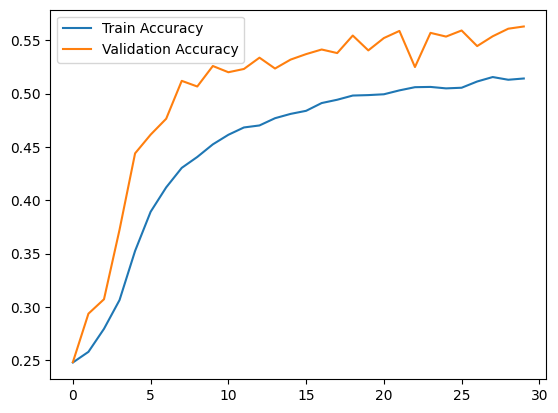

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [25]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load trained model
model = load_model("emotion_model.h5")

# Emotion labels (same order as training)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        # Draw rectangle around face
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)

        # Crop and preprocess face
        face_roi = gray[y:y+h, x:x+w]
        face_roi = cv2.resize(face_roi, (48,48))
        face_roi = face_roi.reshape(1, 48, 48, 1) / 255.0

        # Predict
        prediction = model.predict(face_roi)
        emotion = emotion_labels[prediction.argmax()]

        # Show label
        cv2.putText(frame, emotion, (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.9, (0,255,0), 2)

    cv2.imshow("Real-Time Emotion Detection", frame)

    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 47ms/step
